In [97]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore') 

# First database using A.csv
Running GRU, LSTM, Deep RNN models

In [160]:
data = pd.read_csv("final_project_datasets/stocks/A.csv")
prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
prices = scaler.fit_transform(prices)

# Long Short-Term Memory (LSTM)

In [161]:
scaler = MinMaxScaler()
prices = scaler.fit_transform(prices)

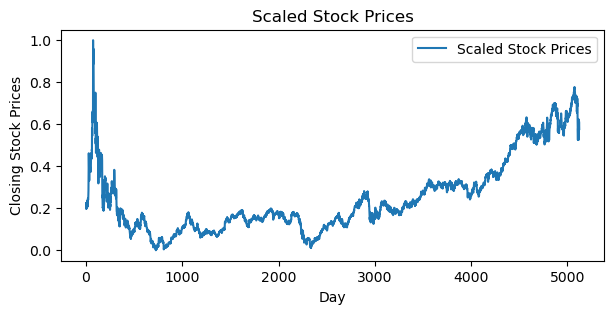

In [162]:
plt.figure(figsize=(7,3),frameon=False)
plt.title('Scaled Stock Prices')
plt.xlabel('Day')
plt.ylabel('Closing Stock Prices')
plt.plot(prices, label='Scaled Stock Prices')
plt.legend()
plt.show()

In [163]:
# Spliting the data 80% train and 20% test
train_size = int(len(prices) * 0.8)
train_prices = prices[:train_size]
test_prices = prices[train_size:]
print("The testing set size:", test_prices.shape)
print("The training set size:", train_prices.shape)

The testing set size: (1025, 1)
The training set size: (4099, 1)


In [164]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data)-seq_length-1):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        X.append(seq)
        y.append(label)
    return torch.tensor(X).float(), torch.tensor(y).float()

In [222]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        h0 = h0.squeeze(1).transpose(0,1)
        c0 = c0.squeeze(1).transpose(0,1)
        out, _ = self.lstm(x.unsqueeze(1), (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


In [223]:
seq_length = 20
X_train, y_train = create_sequences(train_prices, seq_length)
X_test, y_test = create_sequences(test_prices, seq_length)

In [224]:
input_size = 1
hidden_size = 64
output_size = 1
seq_length = len(train_prices)
learning_rate = 0.001
num_epochs = 100

In [225]:
# Initialize LSTM model
model = LSTM(input_size, hidden_size, num_layers).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train model
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors

In [ ]:
# test LSTM model
X_test, y_test = create_sequences(test_prices, seq_length)
with torch.no_grad():
    outputs = model(X_test)
    test_loss = criterion(outputs, y_test)
    predicted_prices = scaler.inverse_transform(outputs.numpy())